[Reference](https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6)

In [3]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 4.3 MB/s 
  Created wheel for pyod: filename=pyod-1.0.6-py3-none-any.whl size=175099 sha256=e826187e3e2e4342aedb8f3f8be417feaffd8b2bb1ce9280ac4e4734552b156c
  Stored in directory: /root/.cache/pip/wheels/5f/24/ba/b986cd4be81d12d0d11130aed62674291bf2da1b891de49aa1
Successfully built pyod


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 25      # number of features

X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,2.396090,2.092611,2.073392,1.988262,1.953473,2.450997,1.631040,1.746182,1.898050,2.380148,...,1.703454,2.502966,2.119108,2.106098,2.165173,2.340826,2.170109,1.749139,1.678661,1.829647
1,1.775596,1.829438,2.054768,1.577190,1.594549,1.373357,1.946647,1.841420,1.595761,2.538094,...,1.974274,1.621608,2.003085,2.076871,1.788868,2.062829,2.084499,2.267568,1.536939,2.132725
2,1.835679,1.612100,2.174908,2.084460,2.472896,2.029110,2.410107,2.282164,2.208201,2.106240,...,2.035652,2.065291,2.197711,2.288806,2.480274,1.946207,1.947120,1.754344,2.265033,2.119050
3,2.420241,2.158485,1.958602,1.903787,2.230522,1.984789,1.964441,2.360795,1.820773,2.116560,...,2.040977,1.511381,1.834332,2.070046,1.911699,1.816916,2.213950,2.099758,2.259999,2.039066
4,1.646926,1.778067,1.760959,1.894087,1.888225,2.228021,2.489542,2.326377,1.969615,2.001316,...,2.063858,2.341009,1.844115,2.076399,1.742857,1.969530,1.821128,1.946249,1.678283,1.797722


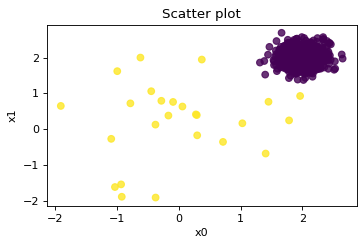

In [5]:
# Plot
plt.figure(figsize=(5, 3), dpi=80)
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

# Step 1: Build the model


In [6]:
from pyod.models.auto_encoder import AutoEncoder
atcdr = AutoEncoder(contamination=0.05, hidden_neurons =[2, 2])
atcdr.fit(X_train)

# Training data
y_train_scores = atcdr.decision_function(X_train)
y_train_pred = atcdr.predict(X_train)

# Test data
y_test_scores = atcdr.decision_function(X_test)
y_test_pred = atcdr.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , atcdr.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                650       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 52        
                                                                 
 dropout_2 (Dropout)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 2)                 6

In [7]:
atcdr.get_params()

{'batch_size': 32,
 'contamination': 0.05,
 'dropout_rate': 0.2,
 'epochs': 100,
 'hidden_activation': 'relu',
 'hidden_neurons': [2, 2],
 'l2_regularizer': 0.1,
 'loss': <function keras.losses.mean_squared_error(y_true, y_pred)>,
 'optimizer': 'adam',
 'output_activation': 'sigmoid',
 'preprocessing': True,
 'random_state': None,
 'validation_size': 0.1,
 'verbose': 1}

# Step 2: Determine the threshold


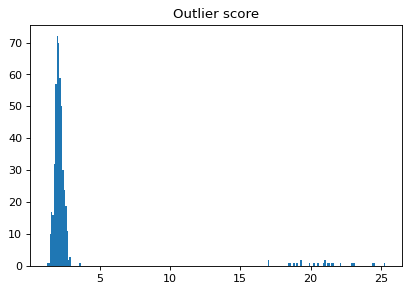

In [8]:
plt.figure(figsize=(6, 4), dpi=80)
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

# Step 3: Descriptive statistics


In [9]:
threshold = atcdr.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,Anomaly_Score
0,Normal,475,95.0,2.01,2.01,2.02,2.00,2.00,2.00,2.0,...,1.99,2.02,2.01,2.00,1.99,2.00,2.0,2.01,1.99,2.12
1,Outlier,25,5.0,-0.02,0.21,-0.05,0.13,0.01,-0.32,0.2,...,-0.07,-0.30,0.11,0.18,0.14,-0.28,0.2,0.09,-0.10,20.90


In [10]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,Anomaly_Score
0,Normal,475,95.0,2.00,1.98,2.02,2.01,1.99,2.01,1.99,...,2.00,2.0,2.01,2.00,2.00,1.99,2.01,1.98,1.99,2.12
1,Outlier,25,5.0,-0.22,-0.45,0.04,-0.26,-0.34,-0.14,0.12,...,-0.07,-0.1,0.15,0.02,-0.36,0.12,0.50,-0.08,0.36,21.55


In [11]:
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_train,y_train_scores,threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


In [12]:
confusion_matrix(y_test,y_test_scores,threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


# Step 4: Averages


In [14]:
pip install combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42884 sha256=b8ea5fe62766e10837df1e446d2f53e1b7252affdfcd954394798c9d5a4b122b
  Stored in directory: /root/.cache/pip/wheels/b1/6e/c9/89dab355d4d5d58b11fe135b5839e8a3acc8b73273ffc68cde
Successfully built combo


In [15]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.auto_encoder import AutoEncoder
atcdr1 = AutoEncoder(contamination=0.05, hidden_neurons =[2, 2])
atcdr2 = AutoEncoder(contamination=0.05, hidden_neurons =[10, 2, 10])
atcdr3 = AutoEncoder(contamination=0.05, hidden_neurons =[15, 10, 2, 10, 15] )

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Just prepare data frames so we can store the model results. There are three models.
train_scores = np.zeros([X_train.shape[0], 3])
test_scores = np.zeros([X_test.shape[0], 3])
atcdr1.fit(X_train_norm)
atcdr2.fit(X_train_norm)
atcdr3.fit(X_train_norm)
    
# Store the results in each column:
train_scores[:, 0] = atcdr1.decision_function(X_train_norm) 
train_scores[:, 1] = atcdr2.decision_function(X_train_norm) 
train_scores[:, 2] = atcdr3.decision_function(X_train_norm)
test_scores[:, 0] = atcdr1.decision_function(X_test_norm) 
test_scores[:, 1] = atcdr2.decision_function(X_test_norm) 
test_scores[:, 2] = atcdr3.decision_function(X_test_norm)

# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 25)                650       
                                                                 
 dropout_4 (Dropout)         (None, 25)                0         
                                                                 
 dense_6 (Dense)             (None, 25)                650       
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 52        
                                                                 
 dropout_6 (Dropout)         (None, 2)                 0         
                                                                 
 dense_8 (Dense)             (None, 2)                

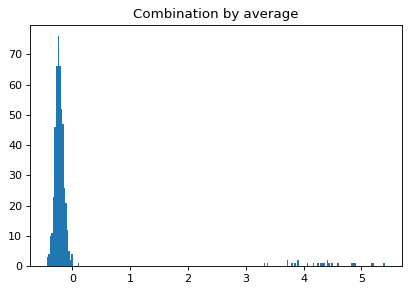

In [16]:
plt.figure(figsize=(6, 4), dpi=80)
# Combination by average
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [17]:
descriptive_stat_threshold(X_train,y_train_by_average, 0.0)

,Group,Count,Count %,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,Anomaly_Score
0,Normal,474,94.8,2.01,2.01,2.03,2.00,2.00,2.00,2.00,...,1.99,2.02,2.01,2.00,1.99,2.00,2.00,2.01,1.99,-0.23
1,Outlier,26,5.2,0.05,0.30,0.01,0.18,0.09,-0.24,0.28,...,0.00,-0.21,0.20,0.25,0.21,-0.18,0.27,0.18,-0.03,4.15


In [18]:
descriptive_stat_threshold(X_test,y_test_by_average, 0.0)

,Group,Count,Count %,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,Anomaly_Score
0,Normal,475,95.0,2.00,1.98,2.02,2.01,1.99,2.01,1.99,...,2.00,2.0,2.01,2.00,2.00,1.99,2.01,1.98,1.99,-0.23
1,Outlier,25,5.0,-0.22,-0.45,0.04,-0.26,-0.34,-0.14,0.12,...,-0.07,-0.1,0.15,0.02,-0.36,0.12,0.50,-0.08,0.36,4.47


In [19]:
confusion_matrix(y_train,y_train_by_average, 0.0)

Pred,0,1
Actual,,
0.0,474,1
1.0,0,25


In [20]:
confusion_matrix(y_test,y_test_by_average, 0.0)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25
